## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

Для начала необходимо импортировать все необходимые библиотеки для проекта

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import lightgbm as lgb

Далее считываю данные, указывая что индексом будет первый столбец с данными

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

После чего сортирую данные по времени и реемплирую их по одному часу

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

Далее описана функция, которая создает признаки. Часть взял из тренажера, но добавил те признаки, которые, на мой взгляд акуальны для предметной области, а именно:
- Квартал
- Месяц
- День
- Цифровое значение дня недели
- Признак, обозначающий выходной этот день или нет
- Час
- Лаг
- Скользящее среднее
- Экспоненциальное сглаживание

In [4]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['isweekend'] = data.dayofweek.isin([5,6])*1
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
#     result = [data['num_orders'][0]] # first value is same as series
#     for n in range(1, len(data['num_orders'])):
#         result.append(alpha * data['num_orders'][n] + (1 - alpha) * data['num_orders'][n-1])
#     data['expsmooth'] = result
    
    return data

Далее создаю признаки со следующими характеристиками:
- количество лагов: 10
- окно для скользящего среднего: 3
- альфа для экспоненциального сглаживания: 0.2

In [5]:
df_ext = make_features(df, 15, 5)

Далее удаляются все пропущенные значения, так как истроически мы не значем их значения

In [6]:
df_ext.dropna(inplace=True)

Разделяю признаки и целевой признак

In [7]:
y = df_ext['num_orders']
X = df_ext.drop(columns=['num_orders'])

Разделяю выборку на обучающую и тестовую в соотношении 9:1 не перемешивая значения

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

### Выводы
- Симпортированны все необходимые библиотеки
- Данные считаны и отсортированны согласно временным меткам
- Произведен ресемплинг по одному часу
- Написана функция, создающая признаки
- Созданы признаки
- Данные разделены на обучающую и тестовую выборки

# 2. Анализ <a name="analys"></a>

Данные необходимо проанализировать

Ниже представлен график, показывающий все заказы за каждый месяц. Из графика видно, что максимальное количество заказов было произведено 20 августа (около 450)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


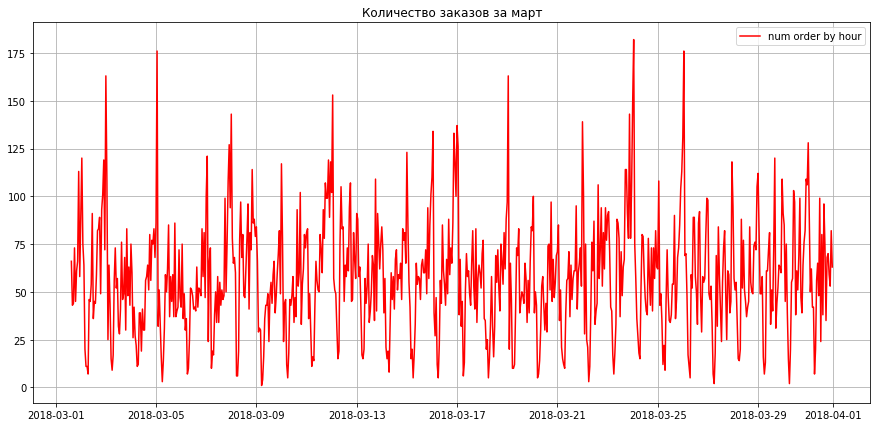

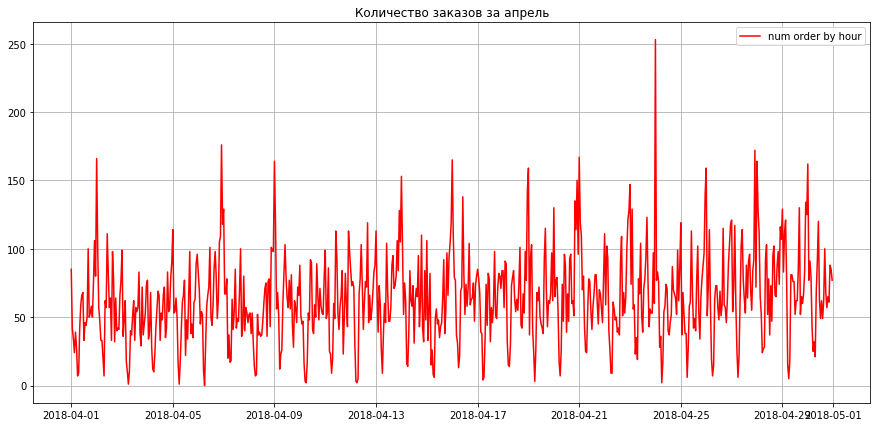

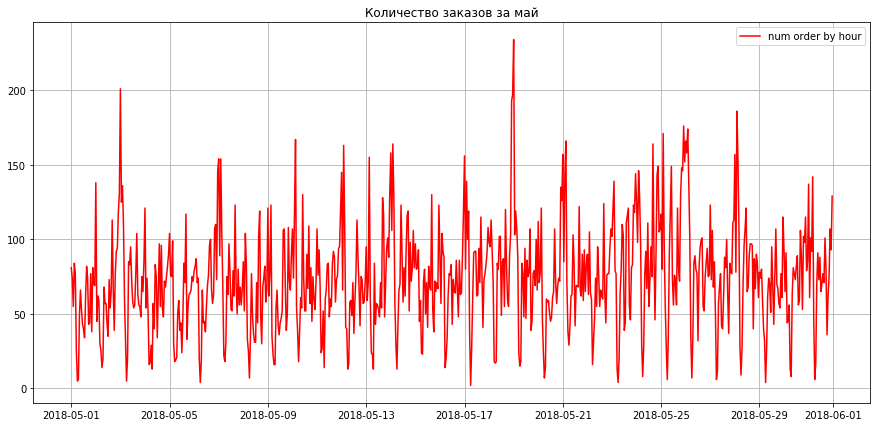

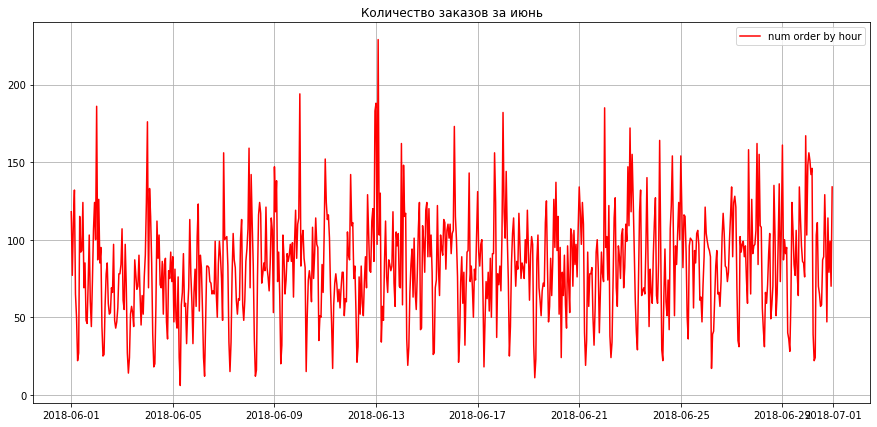

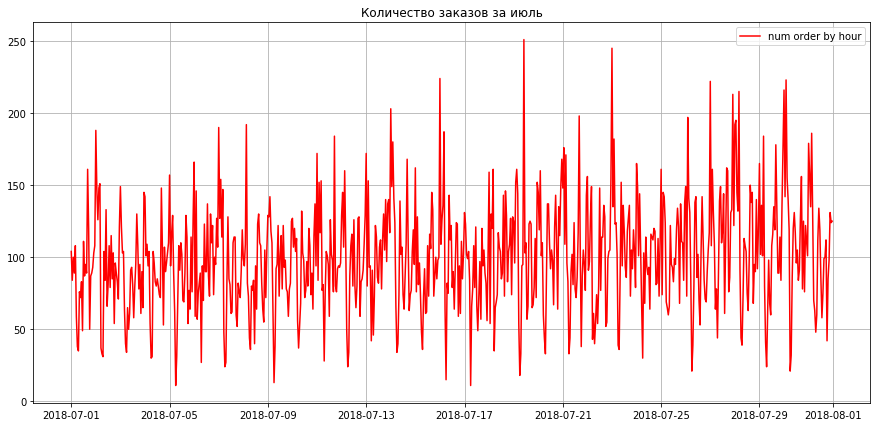

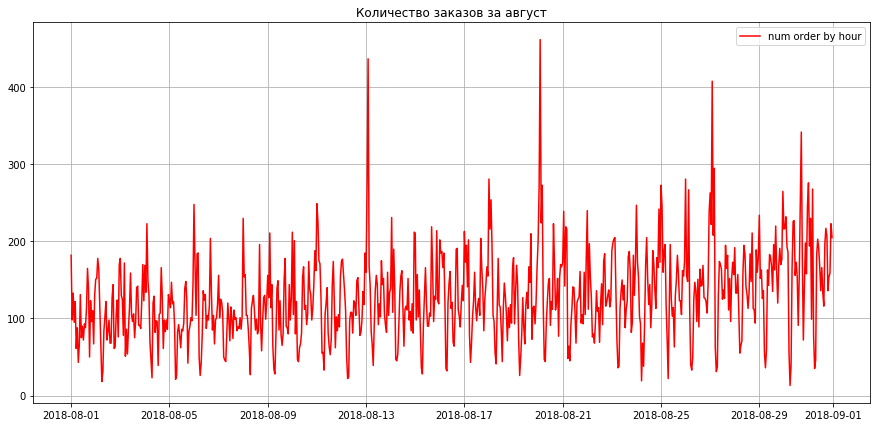

In [9]:
month_name = {
    3: 'Количество заказов за март',
    4: 'Количество заказов за апрель',
    5: 'Количество заказов за май',
    6: 'Количество заказов за июнь',
    7: 'Количество заказов за июль',
    8: 'Количество заказов за август'
}
for num_month in range(3, 9):
    plt.figure(figsize=(15, 7))
    nmonth = '2018-0{nm}'
    month = nmonth.format(nm=num_month)
    plt.plot(df['num_orders'][month:month], "r", label="num order by hour")
    plt.title(month_name[num_month])
    plt.legend(loc="best")
    plt.grid(True);

Ниже приведены кривые отвечащие за количество заказов и скользящее среднее. Как видно из графика, данный метод позволяет избавиться от выбросов

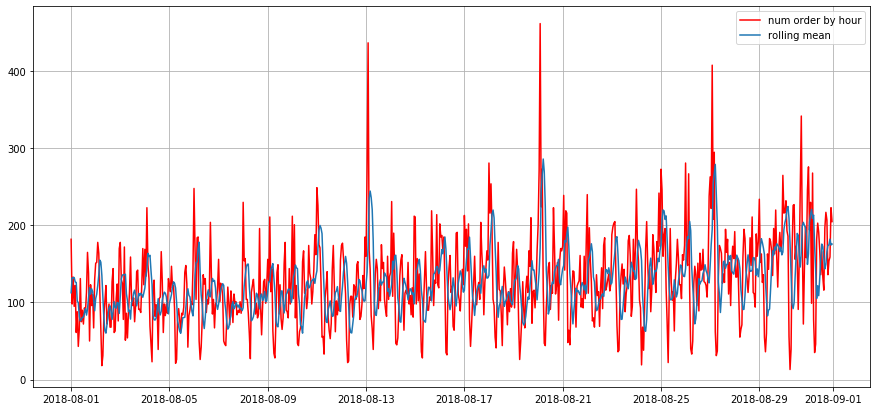

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(df['num_orders']['2018-08':'2018-08'], "r", label="num order by hour")
plt.plot(df['rolling_mean']['2018-08':'2018-08'], label="rolling mean")
plt.legend(loc="best")
plt.grid(True);

Ниже приведены графики тренда, сезонности и остатка. Как видно из графика тренда, количество заказов постепенно растет, график сезонности необходимо смотреть на более узком отрезке, а график остатков я так и не понял как интерпретировать. Буду признателен, если ты сможешь мне с этим помочь:) 

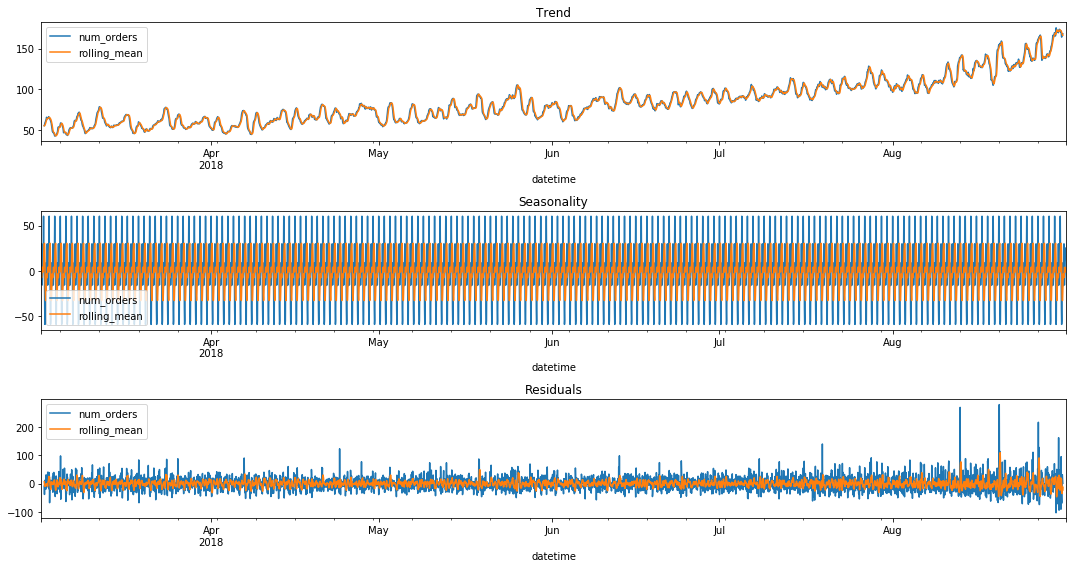

In [11]:
decomposed = seasonal_decompose(df[['num_orders', 'rolling_mean']])
plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Как можно заметить из графика сезонности, наибольшее количество заказов приходится на промежуток от 00 до 02 часов, тогда как на 06 часов приходится наименьшее количетсво заказов

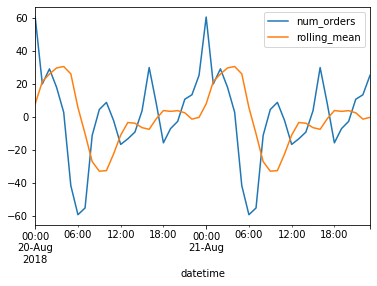

In [12]:
decomposed.seasonal['2018-08-20':'2018-08-21'].plot()

Ниже приведена гистограмма, показывающая количество заказов от того, выходной это день или нет. Как можно заметить, на будние дни приходится больше заказов (так как будних дней банально больше:)

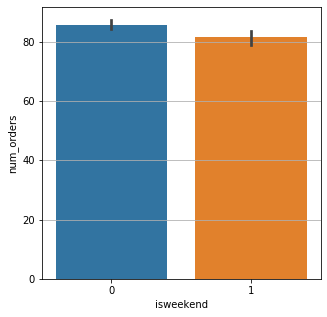

In [13]:
fig, ax1 = plt.subplots(figsize=(5, 5))
plt.grid(True);
sns.barplot(x='isweekend', y='num_orders', data=df, ax=ax1)

Ниже приведена гистограмма, отображающая количество заказов от номера дня в месяце. Как можно заметить, наибольшее количество заказов приходится на 31 число (день зарплат:), а наименьшее на 5 число (день, когда зарплата заканчивается:)

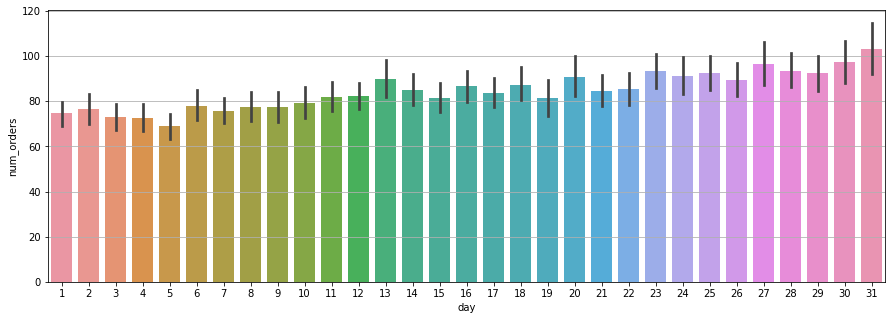

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.grid(True);
sns.barplot(x='day', y='num_orders', data=df, ax=ax1)

Далее представлена диаграмма, отображающая количество заказов от номера дня в неделе. Как можно заметить, меншьше всего заказывают такси по средам, больше всего - по понедельникам (когда просыпают на работу:) и пятницам (когда спешат домой:)

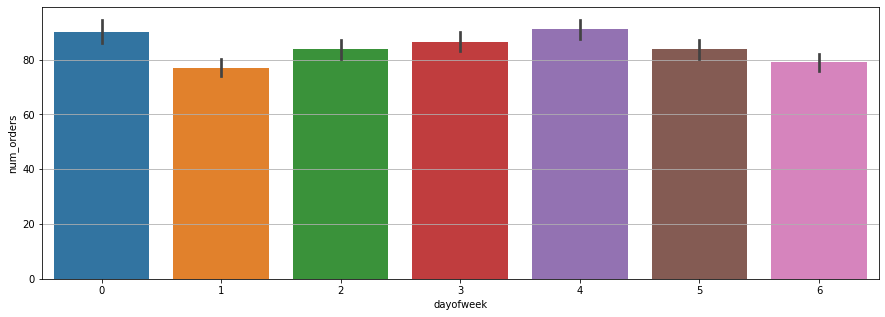

In [15]:
fig, ax1 = plt.subplots(figsize=(15, 5))
plt.grid(True);
sns.barplot(x='dayofweek', y='num_orders', data=df, ax=ax1)

Далее похожая гистограмма, отображающая количество заказов поквартально. Тут можно отметить рост (как и на графике тренда)

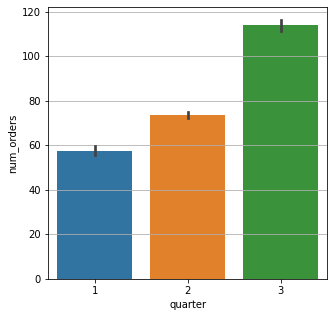

In [16]:
fig, ax1 = plt.subplots(figsize=(5, 5))
plt.grid(True);
sns.barplot(x='quarter', y='num_orders', data=df, ax=ax1)

Далее приведено распределние перечисленных признаков друг от друга. Данные хорошо скомпанованы, особые выбросы отстутсвуют

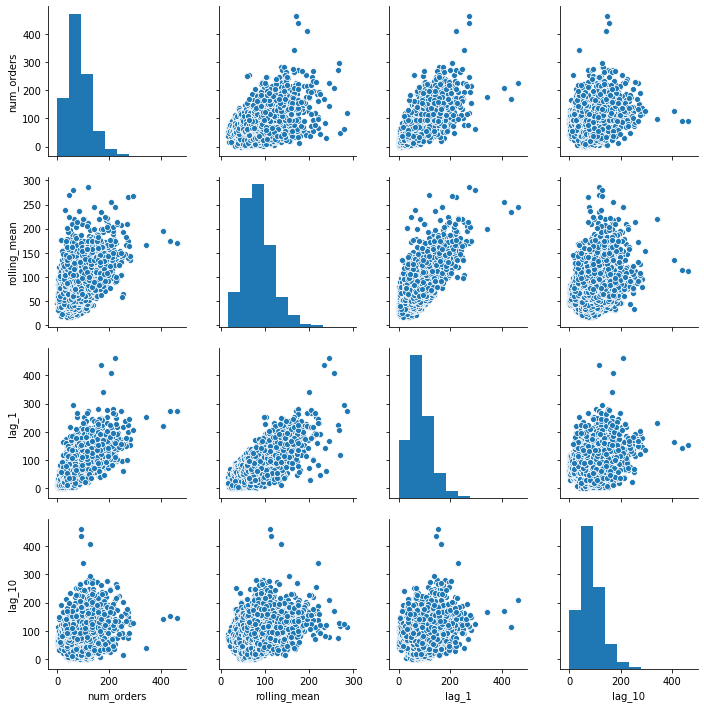

In [17]:
#sns.pairplot(df[['num_orders', 'rolling_mean', 'lag_1', 'lag_10']])

### Выводы
- Меньше всего заказов в марте, больше всего в августе
- Скользящее среднее помогает избавиться от выбросов
- Количество заказов постепенно увеличивается
- Больше всего заказов происходит около 00, меньше всего в 6 утра
- Больше заказов в будние дни, нежели чем в выходные
- Такси чаще всего заказывают по понедельникам и пятницам
- Большого количества выбросов в данных нет

# 3. Обучение

Для решения задачи регрессии выбрано две модели:
- Линейная регрессия, как простая в использовании
- LightGBM, как модель, победившая в прошлом проекте

Для начала необходимо обучить линейную регрессию

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Далее обучается lgbm с перечисленными гиперпараметрами

In [19]:
# ,
#            'n_estimators': 50, 
#            'learning_rate': 0.05,
#             'metric': 'root_mean_squared_error'{'max_depth': 14, 'num_leaves': 150}

In [24]:
%%time
param_grid={'num_leaves': [num_leaves for num_leaves in range (100, 200)],
           'max_depth': [max_depth for max_depth in range (10, 30)]}
tscv = TimeSeriesSplit(n_splits=2)
gs_rf = GridSearchCV(lgb.sklearn.LGBMRegressor(n_estimators=50, learning_rate=0.05,metric='root_mean_squared_error'), param_grid=param_grid, n_jobs=-1, verbose=10, cv=tscv)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_
bp = gs_rf.best_params_

Fitting 2 folds for each of 2000 candidates, totalling 4000 fits
[CV] max_depth=10, num_leaves=100 ....................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=10, num_leaves=100, score=0.424, total=   0.7s
[CV] max_depth=10, num_leaves=100 ....................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=100, score=0.363, total=   1.3s
[CV] max_depth=10, num_leaves=101 ....................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=101, score=0.424, total=   0.8s
[CV] max_depth=10, num_leaves=101 ....................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=101, score=0.363, total=   1.4s
[CV] max_depth=10, num_leaves=102 ....................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=102, score=0.424, total=   0.9s
[CV] max_depth=10, num_leaves=102 ....................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=102, score=0.363, total=   1.8s
[CV] max_depth=10, num_leaves=103 ....................................


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=103, score=0.424, total=   0.8s
[CV] max_depth=10, num_leaves=103 ....................................


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    7.7s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=103, score=0.363, total=   1.4s
[CV] max_depth=10, num_leaves=104 ....................................


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.1s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=104, score=0.424, total=   1.0s
[CV] max_depth=10, num_leaves=104 ....................................


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.1s remaining:    0.0s


[CV] ........ max_depth=10, num_leaves=104, score=0.363, total=   1.6s
[CV] max_depth=10, num_leaves=105 ....................................
[CV] ........ max_depth=10, num_leaves=105, score=0.424, total=   0.9s
[CV] max_depth=10, num_leaves=105 ....................................
[CV] ........ max_depth=10, num_leaves=105, score=0.363, total=   1.3s
[CV] max_depth=10, num_leaves=106 ....................................
[CV] ........ max_depth=10, num_leaves=106, score=0.424, total=   0.8s
[CV] max_depth=10, num_leaves=106 ....................................
[CV] ........ max_depth=10, num_leaves=106, score=0.363, total=   1.4s
[CV] max_depth=10, num_leaves=107 ....................................
[CV] ........ max_depth=10, num_leaves=107, score=0.424, total=   1.0s
[CV] max_depth=10, num_leaves=107 ....................................
[CV] ........ max_depth=10, num_leaves=107, score=0.363, total=   2.2s
[CV] max_depth=10, num_leaves=108 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 103.1min finished


CPU times: user 1h 40min 20s, sys: 1min 11s, total: 1h 41min 32s
Wall time: 1h 43min 4s


In [26]:
bp

{'max_depth': 15, 'num_leaves': 100}

In [25]:
%%time
model_lgb = lgb.sklearn.LGBMRegressor(
    num_leaves=bp["num_leaves"],
    max_depth=bp["max_depth"],
    n_estimators=50, 
    learning_rate=0.05,
    metric='root_mean_squared_error'
)
model_lgb.fit(X_train, y_train)

CPU times: user 1.87 s, sys: 25.8 ms, total: 1.89 s
Wall time: 1.91 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=15,
              metric='root_mean_squared_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
              n_jobs=-1, num_leaves=100, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

### Выводы
- Обучено две модели для решения задачи регрессии

# 4. Тестирование

Далее происходит процесс предсказания для линейной регрессии, а так же выведен график, отображающий распределение предсказнных данных и тестовых

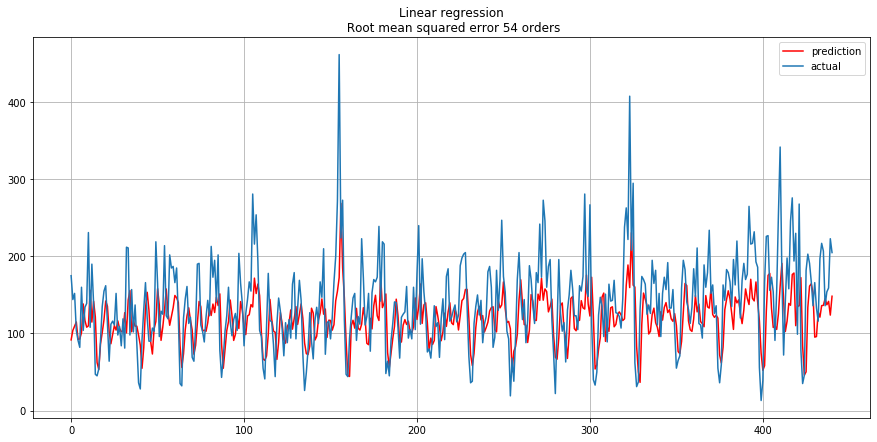

In [20]:
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Root mean squared error {} orders".format(round(mean_squared_error(y_test, prediction)**0.5)))
plt.grid(True);

Модель линейной регрессии показала rmse = 54, что не удовлетворяет требованиям заказчика

Далее происходит предсказание на LgGBMRegressor

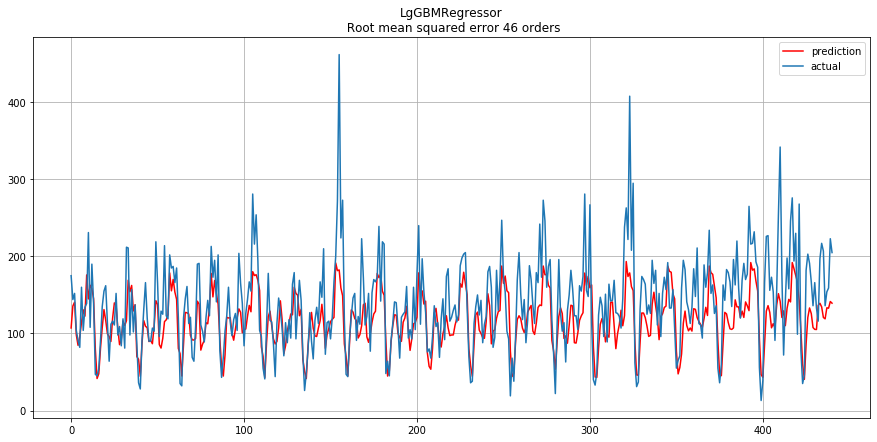

In [27]:
gbm_pred = model_lgb.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(gbm_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("LgGBMRegressor\n Root mean squared error {} orders".format(round(mean_squared_error(y_test, gbm_pred)**0.5)))
plt.grid(True);

LgGBMRegressor показал удовлетворительный результат, требования заказчика были удовлеворены. Стоит отметить, что данная моедль не справилась с предсказанием положительных выбросов

# Выводы
- Произведена сортировка и ресемпл данных
- Написана функция, позволяющая создать признаки для датасета
- Созданы признаки
- Произведен [анализ](#analys) данных
- Обучено две модели для задачи регрессии: LinearRegression и LGBMRegressor
- RMSE для LinearRegression = **53**
- RMSE для LGBMRegressor = **46**